In [33]:
# https://www.youtube.com/watch?v=ok2s1vV9XW0
import gensim.models
import gensim.corpora
import gensim as gs
import pyLDAvis as pvis
import pyLDAvis.gensim
import gensim.models.coherencemodel
import warnings
warnings.filterwarnings('ignore')
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sn
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from gensim.models import FastText
import pprint
from sklearn.metrics import classification_report
from joblib import dump, load
import math
from gensim.models.phrases import Phrases, Phraser
import random

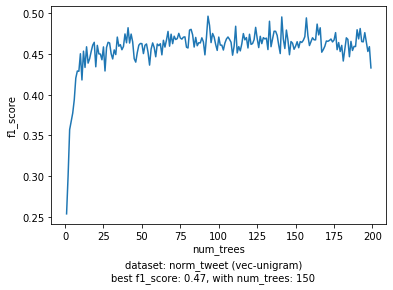

In [117]:
def load_lex_data(dataset_name, feature_set):
    print("loading lex data for", dataset_name, feature_set)
    dataset = pd.read_csv("../cleaned/" + dataset_name + "_clean.csv")
    targets = dataset["a"]
    inputs = dataset[feature_set]
    train_x, test_x, train_y, test_y = train_test_split(inputs, targets, test_size=0.2)
    return train_x, test_x, train_y, test_y    

def load_vector_data(dataset_name, bgr=False):
    print("loading vector data for", dataset_name, bgr)
    sentences = pd.read_csv("../cleaned/" + dataset_name + "_stems.csv", delimiter=",").astype(str).fillna("").values.tolist()
    targets = pd.read_csv("../cleaned/" + dataset_name + "_clean.csv", delimiter=",", dtype = types).astype(str)["a"].tolist() 
    print("...attemtping to load: ", "../models/word_embeddings/" + dataset_name + "_fasttext")
    vector_model = FastText.load("../models/word_embeddings/" + dataset_name + "_fasttext", binary=True)
    # replace placeholders (" "), make one-string-sentences
    print("... replacing placeholders")
    for index, sample in enumerate(sentences): 
            sentences[index] = list(filter((" ").__ne__, sample))
    inputs = [" ".join(sentence) for sentence in sentences]
    sentences
    
    if bgr:
        tokenized = [t.split() for t in inputs]
        phrases = Phrases(tokenized)
        bigram = Phraser(phrases)
        bigrammed = []
        # make bigrams for inputs
        for sentence in inputs:
            sentence = [t.split() for t in [sentence]]
            bigrammed.append(bigram[sentence[0]])
        
        inputs = []
        for sent in bigrammed:
            # if sentence is empty
            inputs.append(np.sum(vector_model.wv[sent], 0).tolist()) if sent else inputs.append(np.zeros(32))
            #if not sent: 
            #    inputs.append(np.zeros(32))
            #else: 
            #    a = np.sum(vector_model.wv[sent], 0).tolist()
            #    inputs.append(a)
    else: 
        inputs = [vector_model.wv[sample] for sample in inputs]

    inputs = np.array(inputs)
    train_x, test_x, train_y, test_y = train_test_split(inputs, targets, test_size=0.2)
    return train_x, test_x, train_y, test_y  

def load_topic_data(dataset_name, num_topics):
    print("loading topic data for", dataset_name)
    # load inputs and labels
    dataset = pd.read_csv("../cleaned/" + dataset_name + "_stems.csv").astype(str).values.tolist() 
    targets = pd.read_csv("../cleaned/" + dataset_name + "_clean.csv")["a"].tolist()
    # remove placeholders from the stems dataset
    for index, sample in enumerate(dataset): 
            dataset[index] = list(filter((" ").__ne__, sample))
    # create dic, copora and lda-model
    dic = gs.corpora.Dictionary.load("../models/dictionary/" + dataset_name + "_dictionary")
    lda_model = gensim.models.ldamulticore.LdaMulticore.load("../models/topic_models/" + dataset_name + "_ldamodel")   
    
    vecs = []
    # for every sentence in the dataset
    for i, sample in enumerate(dataset):
        # get the vector-representations from the doc
        sentence = dic.doc2bow(dataset[i])
        # get the topics from the document (they are ordered by the topic ic)
        topics = lda_model.get_document_topics(sentence, minimum_probability=0.0)
        # write the probability for every topic into a single list
        topic_vec = [topics[i][1] for i in range(num_topics)] 
        # append the prob-vector for this sentence into the all-vectors-list
        vecs.append(topic_vec)
    dataset = vecs
    
    train_x, test_x, train_y, test_y = train_test_split(dataset, targets, test_size=0.2)
    return train_x, test_x, train_y, test_y

def classify_with_rf(dataset_name, feature_set_name, train_x, test_x, train_y, test_y, num_trees): 
    print("building rf model")
    rf = RandomForestClassifier(n_estimators=num_trees)
    print("... training model")
    rf.fit(train_x, train_y)
    print("... calcularing score")
    pred_y = rf.predict(test_x)
    # model metadata
    score, f1_scoore = rf.score(train_x, train_y), f1_score(test_y, pred_y, average="micro")
    #dump(rf, "../models/random_forests/" + dataset_name + "_" + feature_set_name + "_random_forests.joblib") 
    return (test_y, pred_y, score, f1_scoore, num_trees), rf.feature_importances_ 

def get_best_tree_num(dataset_name, feature_set, feature_set_name, max_trees, f="features"):
    indexes, f1 = [], []
    if f == "vec":
        data = load_vector_data(dataset_name)
    elif f == "topic":
        data = load_topic_data(dataset_name, num_topics_dict.get(dataset_name))
    else:        
        data = load_lex_data(dataset_name, features["lex"])
    
    for i in range(1,max_trees):
        print(i)
        results, importance = classify_with_rf(*data, i)
        f1.append(results[3])
        indexes.append(i)

    draw_plot(dataset_name, feature_set_name, indexes, f1, max(f1), f1.index(max(f1))+1)
    
def draw_confusion_matrix(dataset_name, feature_set_name, test_y, pred_y, score, f1_scoore, num_trees, num_topics=None): 
    fig = plt.figure()
    hm = sn.heatmap(confusion_matrix(test_y, pred_y), fmt="d", linewidth=0.5, annot=True, square=True, xticklabels=["h", "s", "a", "f"], yticklabels=["h", "s", "a", "f"], cmap="PuRd")
    ax1 = fig.add_axes(hm)
    ax1.set(xlabel="predicted", ylabel="target")
    if feature_set_name == "topics": desc = "dataset: {} ({}), trained with {} tress, {} topics\nscore: {}, f1_score: {}".format(dataset_name, feature_set_name, num_trees, num_topics, round(score,2), round(f1_scoore,2))
    else: desc = "dataset: {} ({}), trained with {} trees \nscore: {}, f1_score: {}".format(dataset_name, feature_set_name, num_trees, round(score,2), round(f1_scoore,2)) 
    fig.text(0.5, -0.1, desc, ha='center')
    plt.show()
    #fig.savefig("../img/cm_rf_" + dataset_name + "_" + feature_set_name + ".png", bbox_inches="tight")
    
# achtung: Die methode plottet alle coefficients. Immer also nur ein dataset durchlaufen lassen
def draw_coefficients_plot(dataset_name, results, coefficients):
    print(coefficients)
    num_features = len(coefficients[0])
    fig = plt.figure()
    
    plt.plot(range(len(coefficients[0])), coefficients[0], "o", label=results[0][0] + "_" + results[0][1])#, label=classes[i]
    plt.plot(range(len(coefficients[1])), coefficients[1], "o", label=results[1][0] + "_" + results[1][1])#, label=classes[i]
    plt.plot(range(4, 4 + len(coefficients[2])), coefficients[2], "o", label=results[2][0] + "_" + results[2][1])#, label=classes[i]
    desc = "dataset: {}".format(dataset_name)
    fig.text(0.5, -0.05, desc, ha='center')
    plt.xticks(range(0, num_features), features.get("full"), rotation=90)
    #plt.legend()#loc=1
    plt.grid()
    plt.show()
    #fig.savefig("../img/importances_rf_" + dataset_name + ".png", bbox_inches="tight")
    
def load_vector_data(dataset_name, bgr=False):
    print("loading vector data for", dataset_name)
    sentences = pd.read_csv("../cleaned/" + dataset_name + "_stems.csv", delimiter=",").astype(str).values.tolist()
    targets = pd.read_csv("../cleaned/" + dataset_name + "_clean.csv", delimiter=",", dtype = types).astype(str)["a"].tolist() 
    vector_model = FastText.load("../models/word_embeddings/" + dataset_name + "_fasttext")
    # replace placeholders (" "), make one-string-sentences
    print("... replacing placeholders")
    for index, sample in enumerate(sentences): 
            sentences[index] = list(filter((" ").__ne__, sample))
    inputs = [" ".join(sentence) for sentence in sentences]
    tokenized = sentences
    if bgr:
        bigram = Phraser.load("../models/bigrams/bigram_" + dataset_name + ".pkl")
        bigrammed = [bigram[sentence] for sentence in sentences]
        tokenized = bigrammed
    inputs = [np.sum(vector_model.wv[sent], 0).tolist() if sent else np.zeros(32) for sent in tokenized]   
    inputs = np.array(inputs)
    train_x, test_x, train_y, test_y = train_test_split(inputs, targets, test_size=0.2)
    return train_x, test_x, train_y, test_y  

def draw_importances(dataset_name, features, x, importances):
    print("draw i", features)
    # sortiere beide einträge
    x = [e for _,e in sorted(zip(importances,x))]
    importances.sort()
    fig, ax = plt.subplots()
    desc = "dataset: {}({})".format(dataset_name, features)
    fig.text(0.5, -0.05, desc, ha='center')
    plt.scatter(importances, x)
    plt.xlabel("feature importances")
    plt.ylabel("features")
    plt.grid()
    for i, v in enumerate(importances):    
        ax.annotate(str(round(v,2)), (importances[i], x[i]), (importances[i], x[i]))
    #fig.savefig("../img/importances_rf_" + dataset_name + "_" + features + ".png", bbox_inches="tight")
    
def draw_plot(dataset_name, feature_set_name, x, y, best_f1, best_index):
    fig, ax = plt.subplots()
    ax.plot(x, y)
    ax.set(xlabel="num_trees", ylabel="f1_score")
    desc = "dataset: {} ({})\nbest f1_score: {}, with num_trees: {}".format(dataset_name, feature_set_name, best_f1, best_index)
    fig.text(0.5, -0.07, desc, ha='center')
    plt.show()
    #fig.savefig("../img/num_trees_" + dataset_name + "_" + feature_set_name + ".png", bbox_inches="tight")  

In [60]:
all_results = []
importances = []

dataset_name = "norm_tweet"

In [114]:
classes = ["happiness", "sadness", "anger", "fear"]
datasets = ["emotion", "norm_emotion", "tweet", "norm_tweet"]
features = {
    "full": ["wc", "uwc", "ewc", "cpc", "hc", "sc", "ac", "fc"],
    "nolex": ["wc", "uwc", "ewc", "cpc"],
    "lex": ["hc", "sc", "ac", "fc"]
}
classes = ["happiness", "sadness", "anger", "fear"]
trees_for_dataset = {
    "norm_emotion_full": 18,
    "norm_emotion_nolex": 33,
    "norm_emotion_lex": 28, 
    "norm_emotion_vec-unigram": 198,
    "norm_emotion_vec-bigram": 126,
    "norm_emotion_topic": 100,
    "norm_tweet_full": 21,
    "norm_tweet_nolex": 12,
    "norm_tweet_lex": 10,
    "norm_tweet_vec-unigram": 150,
    "norm_tweet_vec-bigram": 131,
    "norm_tweet_topic": 87
}
num_topics_dict = {
    "norm_tweet": 79,
    "norm_emotion": 186
}
types = {
    "text": object, 
    "a": int, 
    "wc": float,
    "uwc": float,
    "ewc": float,
    "cpc": float,
    "hc": float,
    "sc": float,
    "ac": float,
    "c": float
}

In [119]:
all_results = []
importances = []

for dataset in ["norm_tweet", "norm_emotion"]:
    # lex data
    for key, feature_set in features.items(): 
        print("--------------------", dataset, feature_set)
        all_results.append([dataset_name, key, *results])
        importances.append(importance)
    # unigram dataset
    print("--------------------", dataset, "vec-unigram")
    results, coef = classify_with_rf(dataset, "vec-unigram", *load_vector_data(dataset), trees_for_dataset.get(dataset_name + "_" + key, 10))
    all_results.append([dataset, "vec-unigram", *results])
    importances.append(coef)
    # bigram dataset
    print("--------------------", dataset, "vec-bigram")
    results, coef = classify_with_rf(dataset,  "vec-bigram", *load_vector_data(dataset, True), trees_for_dataset.get(dataset_name + "_" + key, 10))
    all_results.append([dataset, "vec-bigram", *results])
    importances.append(coef)
    # topic dataset
    print("--------------------", dataset, "topics-unigram")
    results, coef = classify_with_rf(dataset, "topics", *load_topic_data(dataset, num_topics_dict[dataset]), trees_for_dataset.get(dataset_name + "_" + key, 10))
    all_results.append([dataset, "topics", *results])
    importances.append(coef)
    
for index, result in enumerate(all_results):
    #with open("../reports/report_rf_" + result[0] + "_"  + result[1] + ".txt", 'w') as f:
    #    print((result[0] + "_" + result[1] + " (" + str(result[5]) + "):\n" + 
    #      classification_report(result[2], result[3],target_names=classes)), file=f)
    draw_confusion_matrix(*result)
    #if result[1] == "full" or result[1] == "lex" or result[1] == "nolex":
    #    draw_importances(result[0], result[1], features[result[1]], importances[index])

loading lex data for norm_tweet ['wc', 'uwc', 'ewc', 'cpc', 'hc', 'sc', 'ac', 'fc']
building rf model
... training model
... calcularing score
loading lex data for norm_tweet ['wc', 'uwc', 'ewc', 'cpc']
building rf model
... training model
... calcularing score
loading lex data for norm_tweet ['hc', 'sc', 'ac', 'fc']
building rf model
... training model
... calcularing score
loading vector data for norm_tweet
... replacing placeholders
building rf model
... training model
... calcularing score
loading vector data for norm_tweet
... replacing placeholders
building rf model
... training model
... calcularing score
loading topic data for norm_tweet
building rf model
... training model
... calcularing score
loading lex data for norm_tweet ['wc', 'uwc', 'ewc', 'cpc', 'hc', 'sc', 'ac', 'fc']
building rf model
... training model
... calcularing score
loading lex data for norm_tweet ['wc', 'uwc', 'ewc', 'cpc']
building rf model
... training model
... calcularing score
loading lex data for norm

Process ForkPoolWorker-15:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 103, in worker
    initializer(*initargs)
  File "/home/marcel/.local/lib/python3.6/site-packages/gensim/models/ldamulticore.py", line 334, in worker_e_step
    chunk_no, chunk, worker_lda = input_queue.get()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 94, in get
    res = self._recv_bytes()
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterru

KeyboardInterrupt: 

In [87]:
#get_best_tree_num("norm_emotion", 1, "topic", 200, "topic")
#dataset_name, feature_set, feature_set_name, max_trees, f="features"

In [88]:
# train lrandom forests over the topic distributions
#all_results = []
#importances = []
#for dataset_name in ["norm_emotion"]: 
#    train_x, test_x, train_y, test_y = load_topic_data(dataset_name, num_topics_dict.get(dataset_name))
#    results, importance = classify_with_rf(train_x, test_x, train_y, test_y, trees_for_dataset.get(dataset_name + "_topic", 10))
#    all_results.append([dataset_name, "topics", *results])
#    importances.append(importance)

#for index, result in enumerate(all_results): 
#    with open("../img/report_rf_" + result[0] + "_"  + result[1] + ".txt", 'w') as f:
#        print((result[0] + "_" + result[1] + " (" + str(result[5]) + "):\n" + 
#          classification_report(result[2], result[3],target_names=classes)), file=f)
#    draw_confusion_matrix(*result, num_topics_dict.get(result[0]))